# Test Sound

## Loading and getting Audio MFCC using Librosa

In [1]:
import librosa
from librosa.feature import mfcc
import numpy as np
import sklearn

C:\Users\Chayut\Anaconda3\envs\venv\lib\site-packages\librosa\util\decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit
C:\Users\Chayut\Anaconda3\envs\venv\lib\site-packages\librosa\util\decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import of 'jit' requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit


In [2]:
audio_path = 'a/data/nlpnd_projects/LibriSpeech/dev-clean/1272/141231/1272-141231-0000.flac'
time_series , sampling_rate = librosa.load(audio_path, sr=None)
print(type(time_series), type(sampling_rate))

<class 'numpy.ndarray'> <class 'int'>


In [3]:
print(time_series)
print(sampling_rate)

[-0.00048828 -0.00018311 -0.00137329 ...  0.00079346  0.00091553
  0.00085449]
16000


In [4]:
sample_mfcc = mfcc(time_series, sr=sampling_rate, n_mfcc=13)
print(sample_mfcc.shape)

(13, 146)


In [5]:
sample_mfcc = np.transpose(sample_mfcc)
print(sample_mfcc.shape)

(146, 13)


In this case, mfcc computed 20 mfccs over 145 time frames.\
Displaying the mfcc:

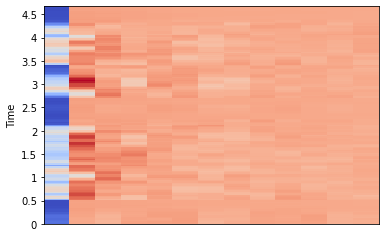

In [6]:
import librosa.display
librosa.display.specshow(sample_mfcc, sr=sampling_rate, y_axis='time')

*Note that mfcc can be calculated with the 'essentia' library as well, see [here](https://musicinformationretrieval.com/mfcc.html#essentia.standard.MFCC)*

## Feature Scaling
Scale to make sure that each coefficient dimension has 0 mean and unit variance.

In [7]:
mfccs = sklearn.preprocessing.scale(sample_mfcc, axis=0)
print(mfccs.mean(axis=0))
print(mfccs.var(axis=0))

[-9.7980237e-09  0.0000000e+00  9.7980237e-09  0.0000000e+00
  8.1650198e-10  1.3064032e-08  3.2660079e-09  8.1650198e-09
  1.3064032e-08  1.6330040e-09  6.5320158e-09  0.0000000e+00
  1.3064032e-08]
[1.0000001  0.9999999  1.         0.9999999  1.0000001  0.99999976
 1.         1.         1.         1.0000001  1.         1.
 0.9999999 ]


C:\Users\Chayut\Anaconda3\envs\venv\lib\site-packages\sklearn\preprocessing\_data.py:173: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
C:\Users\Chayut\Anaconda3\envs\venv\lib\site-packages\sklearn\preprocessing\_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


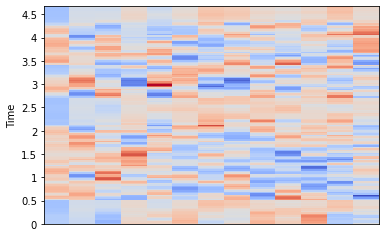

In [8]:
librosa.display.specshow(mfccs, sr=sampling_rate, y_axis='time')

# Getting data from a whole folder (with transcripts)

## Getting the transcripts ready

In [9]:
import helper
import os

Using TensorFlow backend.


In [10]:
if not os.path.exists('1272-141231.txt'):
    helper.create_transcript_from_folder('./a/data/nlpnd_projects/LibriSpeech/dev-clean/', '1272', '141231', '1272-141231.txt')

In [11]:
if not os.path.exists('transcript.txt'):
    helper.create_transcript('./a/data/nlpnd_projects/LibriSpeech/dev-clean/', ['1272', '1462', '1673'], 'transcript.txt')

## Getting Train and Test set

In [12]:
train_path, train_duration, train_text, test_path, test_duration, test_text, validation_path, validation_duration, validation_text = helper.train_test_val_split('transcript.txt')

In [13]:
sorted_train_path, sorted_train_duration, sorted_train_text = helper.sort_data(train_path, train_duration, train_text)
# test_path, test_duration, test_text = helper.sort_data(test_path, test_duration, test_text)
# validation_path, validation_duration, validation_text = helper.sort_data(validation_path, validation_duration, validation_text)

Data Sorted!


*TODO:* **Suggestion to self: 1st epoch train by sorted duration, 2nd onwards train randomly**

In [19]:
print(len(train_path))

155


# Building a Model

## Importing necessary dependencies

In [14]:
from keras import backend as K
from keras.models import Model
from keras.layers import (BatchNormalization, Conv1D, Dense, Input, Dropout,
    TimeDistributed, Activation, Bidirectional, SimpleRNN, GRU, LSTM)

## Creating a sample model: RNN + TimeDistributed Dense

In [15]:
def rnn_model(input_dim, units, activation, output_dim=29):
    input_data = Input(shape=(None, input_dim), name='the_input')
    simp_gru = GRU(units=units, activation=activation, return_sequences=True, implementation=2, name='model_gru')(input_data)
    bn = BatchNormalization()(simp_gru)
    td = TimeDistributed(Dense(output_dim=output_dim))(bn)
    y_pred = Activation('softmax')(td)
    model = Model(inputs=input_data, outputs=y_pred)
    model.output_length = lambda x:x
    print(model.summary())
    return model

In [16]:
model_1 = rnn_model(input_dim=13, # change to 13 if you would like to use MFCC features
                    units=200,
                    activation='relu')

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 13)          0         
_________________________________________________________________
model_gru (GRU)              (None, None, 200)         128400    
_________________________________________________________________
batch_normalization_1 (Batch (None, None, 200)         800       
_________________________________________________________________
time_distributed_1 (TimeDist (None, None, 29)          5829      
_________________________________________________________________
activation_1 (Activation)    (None, None, 29)          0         
Total params: 135,029
Trainable params: 134,629
Non-trainable params: 400
_________________________________________________________________
None


<ipython-input-15-18c267c032fa>:5: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=29)`
  td = TimeDistributed(Dense(output_dim=output_dim))(bn)


In [17]:
_, feats_mean, feats_std = helper.fit_train(train_path, train_duration, train_text)

In [18]:
helper.train_model(input_model=model_1,
                   train_path = train_path,
                   train_duration = train_duration,
                   train_text = train_text,
                   validation_path = validation_path,
                   validation_duration = validation_duration,
                   validation_text = validation_text,
                   feats_mean = feats_mean,
                   feats_std = feats_std,
                   # test_path = test_path,
                   # test_duration = test_duration,
                   # test_text = test_text,
                   pickle_path='model_1.pickle', 
                   save_model_path='model_1.h5')

Epoch step: 7
Validation step: 1
Epoch 1/20
7/7 [==============================] - 13s 2s/step - loss: 412.9431 - val_loss: 486.2725
Epoch 2/20
7/7 [==============================] - 12s 2s/step - loss: 325.5335 - val_loss: 433.6587
Epoch 3/20
7/7 [==============================] - 12s 2s/step - loss: 302.5430 - val_loss: 395.5069
Epoch 4/20
7/7 [==============================] - 11s 2s/step - loss: 286.6120 - val_loss: 375.5503
Epoch 5/20
7/7 [==============================] - 11s 2s/step - loss: 275.0860 - val_loss: 356.3982
Epoch 6/20
7/7 [==============================] - 11s 2s/step - loss: 266.3161 - val_loss: 335.0105
Epoch 7/20
7/7 [==============================] - 11s 2s/step - loss: 260.8431 - val_loss: 323.0617
Epoch 8/20
7/7 [==============================] - 11s 2s/step - loss: 255.3682 - val_loss: 315.4656
Epoch 9/20
7/7 [==============================] - 11s 2s/step - loss: 250.9209 - val_loss: 310.6775
Epoch 10/20
7/7 [==============================] - 11s 2s/step - lo